In [1]:
import itertools
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from time import time
import pickle
from tabulate import tabulate
%matplotlib inline

Using TensorFlow backend.


### Data

In [2]:
ts_key = 'ts_features'
spec_key = 'spec_features'
labels_key = 'labels'
model_dir = './models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
t0 = time()

In [3]:
db = np.load('./db.npy').item()
print(list(db.keys()))
print('TS features shape:', db['ts_features'].shape)
print('Spectra features shape:', db['spec_features'].shape)

['fats', 'fats_keys', 'ts_names', 'vae', 'vae_keys', 'spec_names', 'labels', 'ts_features', 'spec_features']
TS features shape: (2554, 7)
Spectra features shape: (2554, 2)


Check if features in [0,1] range

In [4]:
# Normalize
min_max_ts = np.array([db[ts_key].min(axis=0), db[ts_key].max(axis=0)]).T
min_max_spec = np.array([db[spec_key].min(axis=0), db[spec_key].max(axis=0)]).T
print(np.around(min_max_ts, 3))
print(np.around(min_max_spec, 3))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[0. 1.]
 [0. 1.]]


### Utils

In [5]:
def plot_cm(y_true, y_pred, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    
    labels = np.unique(y_true)
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def train_predict_rf(data, target, save=False, base_path=None):
    print("Features dim:", data.shape[-1])
    
    skf = StratifiedKFold(n_splits=10)
    probs_kfold = []
    target_kfold = []
    i = 0 
    for train_index, test_index in skf.split(data, target):
        clf = RandomForestClassifier(n_estimators=200)
        clf.fit(data[train_index], target[train_index])
        probs = clf.predict_proba(data[test_index])
        k_df = pd.DataFrame(probs, columns=clf.classes_)
        k_df["index"] = test_index
        k_df["target"] = target[test_index]
        if save:
            pickle.dump(clf, open(base_path+str(i)+'.model', 'wb'))
            k_df["rf_index"] = i
        probs_kfold.append(k_df)
        i +=1
    probs_df = pd.concat(probs_kfold)
    probs_df = probs_df.set_index("index")
    probs_df = probs_df.sort_index()
    
    # Check if all index
    all_in = np.array_equal(probs_df.index, list(range(data.shape[0])))
    if not all_in:
        print("Not all index in")
        return None
    cls_cols = list(set(probs_df.columns) -set(["rf_index", "target"]))
    pred_int = np.argmax(probs_df[cls_cols].values, axis=1)
    str_classes = dict(zip(range(len(cls_cols)), cls_cols))
    pred = list(map(lambda x: str_classes[x], pred_int))
    
    acc = metrics.accuracy_score(target,pred)
    print("Accuracy: ", acc)
    
    labels = cls_cols
    f1_score = metrics.f1_score(target, pred, labels = labels, average=None)
    f1_score = list((np.round(f1_score,decimals=3)).reshape((1,-1))[0])
    f1_score = [["F-score"] + f1_score]
    table = tabulate(f1_score, labels, tablefmt="fancy_grid")
    print(table)

    plt.figure(figsize=(6,6))
    plot_cm(target, pred, normalize=False)
    
    return probs_df

### Labels

In [6]:
target = db[labels_key]
vals, counts = np.unique(target, return_counts=True)
dict(zip(vals, counts))

{'EA': 148, 'EW': 749, 'RRab': 343, 'RRc': 1193, 'RRd': 78, 'RS CVn': 43}

### TS Classify

Features dim: 7
Accuracy:  0.8472983555207517
╒═════════╤═══════╤═══════╤═══════╤══════════╤═══════╤════════╕
│         │   RRd │   RRc │    EW │   RS CVn │    EA │   RRab │
╞═════════╪═══════╪═══════╪═══════╪══════════╪═══════╪════════╡
│ F-score │ 0.067 │ 0.893 │ 0.837 │    0.419 │ 0.847 │  0.842 │
╘═════════╧═══════╧═══════╧═══════╧══════════╧═══════╧════════╛
Confusion matrix, without normalization


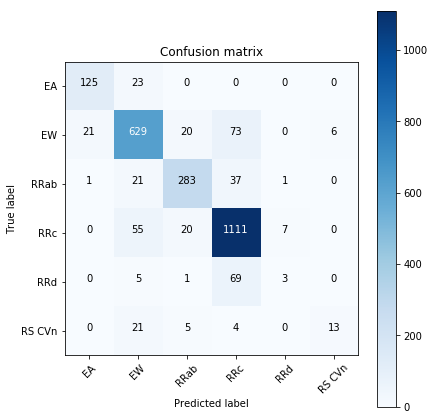

In [7]:
data = db[ts_key]
probs_ts = train_predict_rf(data, target, save=False, base_path=None)

### Spec Classify

Features dim: 2
Accuracy:  0.5806577916992952
╒═════════╤═══════╤═══════╤══════╤══════════╤═══════╤════════╕
│         │   RRd │   RRc │   EW │   RS CVn │    EA │   RRab │
╞═════════╪═══════╪═══════╪══════╪══════════╪═══════╪════════╡
│ F-score │ 0.061 │ 0.711 │ 0.58 │    0.375 │ 0.081 │  0.252 │
╘═════════╧═══════╧═══════╧══════╧══════════╧═══════╧════════╛
Confusion matrix, without normalization


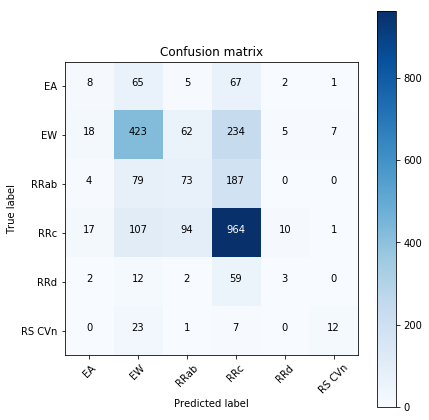

In [8]:
data = db[spec_key]
probs_spec = train_predict_rf(data, target, save=False, base_path=None)

### Mix classification

Features dim: 9
Accuracy:  0.8719655442443226
╒═════════╤═══════╤═══════╤═══════╤══════════╤═══════╤════════╕
│         │   RRd │   RRc │    EW │   RS CVn │    EA │   RRab │
╞═════════╪═══════╪═══════╪═══════╪══════════╪═══════╪════════╡
│ F-score │  0.22 │ 0.907 │ 0.878 │    0.554 │ 0.857 │  0.863 │
╘═════════╧═══════╧═══════╧═══════╧══════════╧═══════╧════════╛
Confusion matrix, without normalization


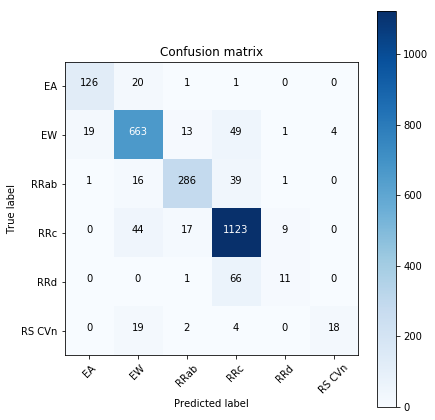

In [9]:
data = np.hstack([db[ts_key],db[spec_key]])
probs_mix = train_predict_rf(data, target, save=True, base_path=model_dir+'mix_rf')

In [10]:
t1 = np.round(time()-t0, decimals=2)
msg = 'Time '+str(t1)+'.s'
print(msg)

Time 24.5.s


## Classification change behavior

In [11]:
vals, counts = np.unique(probs_mix['target'], return_counts=True)
print(dict(zip(vals, counts)))
print("Total:", np.sum(counts))

{'EA': 148, 'EW': 749, 'RRab': 343, 'RRc': 1193, 'RRd': 78, 'RS CVn': 43}
Total: 2554


In [12]:
def get_predictions(probs_ts, probs_mix):
    probs = pd.DataFrame()
    for column in probs_ts.columns:
        if not 'target' in column:
            probs[column+'_ts'] = probs_ts[column]

    for column in probs_mix.columns:
        if not 'target' in column:
            probs[column+'_mix'] = probs_mix[column]
            
    probs['target'] = probs_ts['target']
    probs['ts_names'] = db['ts_names']
    probs['spec_names'] = db['spec_names']

    prefix = np.unique(probs['target'])
    cols_ts =  prefix + '_ts'
    cols_mix = prefix + '_mix'
    idx = range(probs.shape[0])
    probs['pred_ts'] = probs[cols_ts].idxmax(axis=1)
    probs['pred_ts_prob'] = probs.lookup(idx,probs['pred_ts'])
    probs['ground_ts_prob'] = probs.lookup(idx,probs['target'].apply(lambda t: t+'_ts'))
    probs['pred_mix'] = probs[cols_mix].idxmax(axis=1)
    probs['pred_mix_prob'] = probs.lookup(idx,probs['pred_mix'])
    probs['ground_mix_prob'] = probs.lookup(idx,probs['target'].apply(lambda t: t+'_mix'))
    probs['pred_ts'] =  probs['pred_ts'].apply(lambda row: row.rstrip('_ts'))
    probs['pred_mix'] =  probs['pred_mix'].apply(lambda row: row.rstrip('_mix'))
    return probs

In [13]:
probs = get_predictions(probs_ts, probs_mix)
probs.to_csv('classification.csv', index=False)
probs.head()

,EA_ts,EW_ts,RRab_ts,RRc_ts,RRd_ts,RS CVn_ts,EA_mix,EW_mix,RRab_mix,RRc_mix,...,rf_index_mix,target,ts_names,spec_names,pred_ts,pred_ts_prob,ground_ts_prob,pred_mix,pred_mix_prob,ground_mix_prob
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.030,0.005,0.945,0.020,0.0,0.000,0.030,0.000,0.970,...,0,RRc,1132062052528,spec-2112-53534-0521.fits,RRc,0.945,0.945,RRc,0.970,0.970
1,0.0,0.950,0.005,0.040,0.005,0.0,0.005,0.965,0.015,0.015,...,0,EW,1001072050924,spec-3307-54970-0075.fits,EW,0.950,0.950,EW,0.965,0.965
2,0.0,0.005,0.985,0.010,0.000,0.0,0.000,0.000,0.995,0.000,...,0,RRab,1121054053106,spec-2477-54058-0261.fits,RRab,0.985,0.985,RRab,0.995,0.995
3,0.0,0.035,0.025,0.925,0.015,0.0,0.000,0.050,0.005,0.930,...,0,RRc,1126077024700,spec-2474-54564-0169.fits,RRc,0.925,0.925,RRc,0.930,0.930
4,0.0,0.040,0.000,0.935,0.025,0.0,0.000,0.080,0.000,0.815,...,0,RRc,1138033064612,spec-3661-55614-0596.fits,RRc,0.935,0.935,RRc,0.815,0.815


In [14]:
t2 = np.round(time()-t0, decimals=2)
msg = 'Time '+str(t2)+'.s'
print(msg)

Time 24.64.s
